Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is an unsupervised machine learning algorithm used for clustering based on points' density concentration.  It uses parameters epsilon and minimum points to define the model, where epsilon is the radius around a point where the algorithm searches for neighbors and miniumum points is the minimum number of neighboring points within radius epsilon.

This algorithm does not require the number of clusters to be known, an advantage over other clustering algorithms.  However, it must be properly tuned (parameterize epsilon and minimum points) to work properly.

In [251]:
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

generate sample data withn sklearn's datasets

In [252]:
centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
X, _ = make_blobs(
    n_samples=500, centers=centers, cluster_std=0.4, random_state=0
)

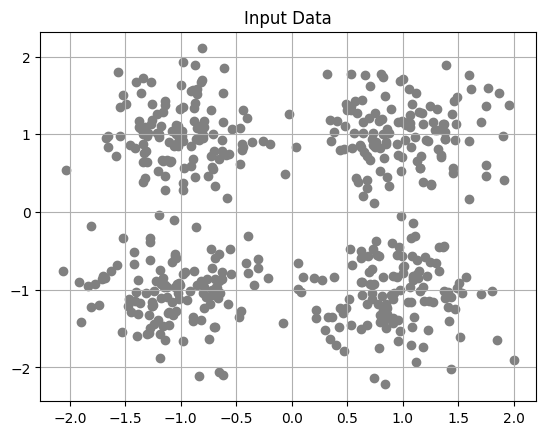

In [253]:
fig0, ax0 = plt.subplots()

ax0.scatter(X[:, 0], X[:, 1], c='grey')
ax0.grid(True)
ax0.set_title('Input Data')
plt.show()

Variables that influence the density-based clustering algorithm

epsilon:  maximum distance between two points to be considered neighbors

minPts:  minimum number of points required within neighborhood for a point to be considered a core point. 

In [254]:
eps = 0.3
min_pts = 10

In [255]:
#  linear distance between 2 points
def get_equclidean_distance(pt1, pt2):
    dist = np.sqrt(
        (pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2
        )
    
    return dist

Get core points from the data.  These are the points that satisfy the epsilon and minimum points criteria defined above.

In [256]:
def get_core_points(data_set):

    core_points = []
    for center_idx, center_point in enumerate(data_set):

        center_neighbors = []
        for idx, neighbor_point in enumerate(data_set):

            #  ommits the center point from being considered
            if center_idx!=idx:
                dist = get_equclidean_distance(pt1=center_point, pt2=neighbor_point)

                #  Identify center points with neighboring points within distance epsilon
                if dist<=eps:
                    center_neighbors.append(neighbor_point)


        #  Of center points points with neighbors, identify center points with at least the miniumum number of neighbors as core points
        number_of_neighbors = len(center_neighbors)
        if number_of_neighbors>=min_pts:
            core_points.append(center_point)

    return core_points

In [257]:
core_points = get_core_points(data_set=X)

In [258]:
x = [point[0] for point in core_points]
y = [point[-1] for point in core_points]

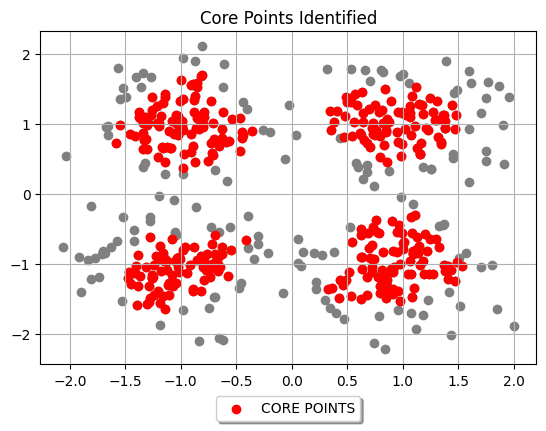

In [259]:
fig1, ax1 = plt.subplots()

ax1.scatter(X[:, 0], X[:, 1], c='grey')
ax1.scatter(x, y, c='red', label='CORE POINTS')
ax1.grid(True)

#  legend box
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),
          fancybox=True, shadow=True, ncol=5)

ax1.set_title('Core Points Identified')
plt.show()

Get non-core neighbors.  These are the neighboring points around the core points that satisfy the epsilon creitera relative to one of the core points.  These points can be added to a cluster, but will NOT extend the cluster.  In other words, no new points can be added to the cluster by proximity to a non-core neighbor.

In [260]:
#  these are the points from the data that did not qualify as core points
def get_non_core_points(data_set, core_points):
    
    non_core_points=[]
    for data_point in data_set:
        
        #  Identify core points in the input data set
        point_intersection=[]
        for core_point in core_points:
            common_pt = set(core_point)==set(data_point)
            point_intersection.append(common_pt)


        #  Only append values in the input data set that are NOT core points
        if not bool(sum(point_intersection)):
            non_core_points.append(data_point)

    return non_core_points

In [261]:
non_core_points = get_non_core_points(X, core_points)

In [262]:
#  non-core neighbors will join a cluster, but won't extend the cluster (i.e. will not make the cluster larger)

def get_non_core_neighbors(core_points, non_core_points, eps):
    non_core_neighbors=[]

    for nc_point in non_core_points:
        for c_point in core_points:

            dist = get_equclidean_distance(pt1=nc_point, pt2=c_point)
            
            #  Identify non-core points with neighboring core points within distance epsilon
            if dist<=eps:
                non_core_neighbors.append(nc_point)

    return non_core_neighbors

In [263]:
non_core_neighbors = get_non_core_neighbors(core_points, non_core_points, eps)

In [264]:
p = [point[0] for point in non_core_neighbors]
q = [point[-1] for point in non_core_neighbors]

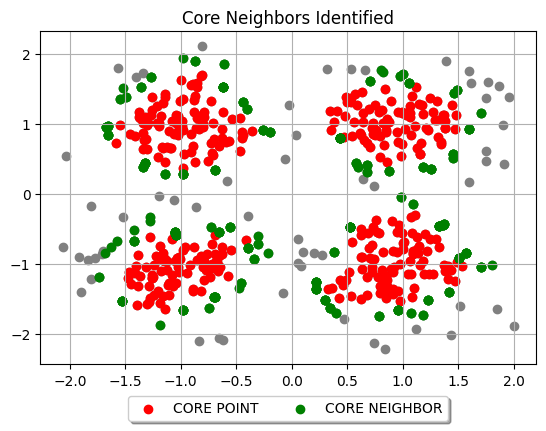

In [265]:
fig2, ax2 = plt.subplots()

ax2.scatter(X[:, 0], X[:, 1], c='grey')
ax2.scatter(x, y, c='red', label='CORE POINT')
ax2.scatter(p, q, c='green', label='CORE NEIGHBOR')
ax2.grid(True)

#  legend box
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),
          fancybox=True, shadow=True, ncol=5)

ax2.set_title('Core Neighbors Identified')
plt.show()

In [266]:
core_points.extend(non_core_neighbors)

x = [point[0] for point in core_points]
y = [point[-1] for point in core_points]

Identify outlier points

In [267]:
def get_outliers(data_set, core_points):
    
    outliers=[]
    for data_point in data_set:
        
        #  Identify outlier points in the input data set
        point_intersection=[]
        for core_point in core_points:
            common_pt = set(core_point)==set(data_point)
            point_intersection.append(common_pt)


        #  Only append values in the input data set that are NOT core points
        if not bool(sum(point_intersection)):
            outliers.append(data_point)

    return outliers

In [268]:
outliers = get_outliers(X, core_points)

In [269]:
r = [point[0] for point in outliers]
s = [point[-1] for point in outliers]

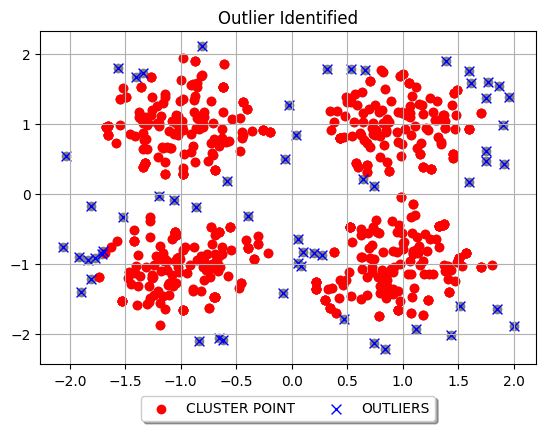

In [270]:
fig3, ax3 = plt.subplots()

ax3.scatter(X[:, 0], X[:, 1], c='grey')
ax3.scatter(x, y, c='red', label='CLUSTER POINT')
ax3.scatter(r, s, c='blue', marker='x',s=50, linewidth=1, label='OUTLIERS')
ax3.grid(True)

#  legend box
box = ax3.get_position()
ax3.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),
          fancybox=True, shadow=True, ncol=5)
ax3.set_title('Outlier Identified')
plt.show()

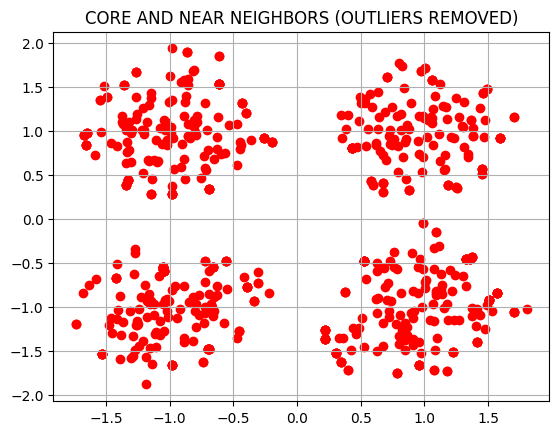

In [271]:
fig4, ax4 = plt.subplots()

ax4.scatter(x, y, c='red')
ax4.grid(True)
ax4.set_title('CORE AND NEAR NEIGHBORS (OUTLIERS REMOVED)')
plt.show()

-----

We will build a distance table, which will be an n x n matrix to define each point's distance from all other points.  Instead of tracking coordinate points, we will build a dictionary where the key is a unique point index and the value is the point's coordinate.  This makes it easier to iterate through the data as a single variable instead of a coordinate.

In [272]:
data_coords=dict()
for idx, point in enumerate(core_points):
    array2list = [float(pt) for pt in point]
    data_coords[idx]=array2list

Build a table where the row and column intersection is the distance between the points corresponding to the row and column indices.

In [273]:
def build_distance_table(row_count, col_count):

    distance_table = []
    for row_idx in range(row_count):

        row_data = []
        for col_idx in range(col_count):
            row_data.append((row_idx, col_idx))

        distance_table.append(row_data)

    return distance_table

In [274]:
data_point_count = len(data_coords.keys())
distance_table = build_distance_table(row_count=data_point_count, col_count=data_point_count)

Calculate the distances between points and record in the distance table.

In [275]:
def get_distances(data_coords, distance_table):

    for row in distance_table:
        for col in row:

            row_idx = col[0]
            col_idx = col[-1]

            center_point = data_coords[row_idx]
            neighbor_point = data_coords[col_idx]

            dist = get_equclidean_distance(pt1=center_point, pt2=neighbor_point)
            distance_table[col[0]][col[-1]]=round(float(dist), 2)

    return distance_table

In [276]:
distance_table = get_distances(data_coords=data_coords, distance_table=distance_table)

Identify each point's nearest neighbors within distance eps.

In [277]:
#  get point_neighbors from distance table
def get_cluster_point_neighbors(distance_table, eps):

    point_neighbors = {row_idx:[] for row_idx, _ in enumerate(distance_table)}
    for row_idx, row in enumerate(distance_table):
        point_neighbors_check = [idx for idx, dist in enumerate(row) if dist<=eps]
        point_neighbors[row_idx]=point_neighbors_check

    return point_neighbors

In [278]:
point_neighbors = get_cluster_point_neighbors(distance_table, eps)

This is where the clustering happens!  some points, although in the same cluster, may not have all cluster members identified, so this syncs all cluster members by enabling points to inherit the neighbors's immediate neighbors within a cluster.

The idea is that point A is within eps distance of point B, and point B is within eps distance of point C.  While all 3 points are in the same cluster, point A and point C are not within eps distance of one another.  Since point B is between A and C and of eps distance from both, according to the distance table, we can conclude that A and C are in the same cluster even if they are not immediate neighbors.

Think of this as two points that are on opposite ends of the same cluster, but are related by a chain of points that satisfy the DBSCAN parameters defined.

In [279]:
#  combine common neighbors' lists
def sync_neighbors(point_neighbors):

    clusters = {row_idx:[] for row_idx in point_neighbors.keys()}
    for row_idx, row in point_neighbors.items():


        for neighbor_idx in row:
            neighbors_neighbors = point_neighbors[neighbor_idx]


            #  find values in row that are missing from neighbors_neighbors and add them in
            missing_vals = list(set(row)-set(neighbors_neighbors))
            neighbors_neighbors.extend(missing_vals)
            clusters[neighbor_idx].extend(neighbors_neighbors)


            # #  find values in neighbors_neighbors that are missing from row and add them in
            missing_vals = list(set(neighbors_neighbors)-set(row))
            row.extend(missing_vals)
            clusters[row_idx].extend(row)

    return clusters

In [280]:
clusters = sync_neighbors(point_neighbors)

Remove all duplicate point indices within a cluster.

In [281]:
#  only unique values in the dictionary value lists
def remove_duplicate_neighbors(clusters):
    
    for key, val in clusters.items():
        clusters[key]=list(set(val))

    return clusters

In [282]:
clusters = remove_duplicate_neighbors(clusters)

Remove all duplicate clusters (cluster groupings with the same point indices).

In [283]:
#  get unique clusters
def remove_duplicate_clusters(clusters):

    clusters_list=[]
    for cluster_idx, cluster_points in clusters.items():

        cluster_points.sort()  # sort for accurate comparison below
        if cluster_points not in clusters_list:
            clusters_list.append(cluster_points)

    return clusters_list

In [284]:
clusters_list = remove_duplicate_clusters(clusters)

Relate the point indices back to the coorindates and plot.

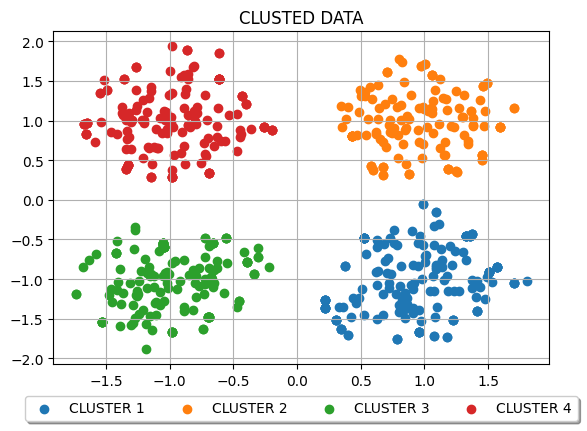

In [285]:
fig5, ax5 = plt.subplots()

# relate the point indices back to the coorindates
for cluster_idx, cluster in enumerate(clusters_list):

    point_coordinates = [data_coords[cluster_point] for cluster_point in cluster]
    ax5.scatter(list(map(itemgetter(0), point_coordinates)), list(map(itemgetter(-1), point_coordinates)), label=f'CLUSTER {cluster_idx+1}')

ax5.set_title('CLUSTED DATA')
ax5.grid(True)


#  legend box
box = ax5.get_position()
ax5.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax5.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),
          fancybox=True, shadow=True, ncol=5)


plt.show()


-----

DBSCAN can also be implemented with the scikit-learn library

In [286]:
from sklearn.cluster import DBSCAN

In [287]:
dbscan = DBSCAN(eps=0.3, min_samples=9)

In [288]:
clusters = dbscan.fit(X)
labels = clusters.labels_

The result is VERY similar!  I had to tune my parameters a little bit, but the same clusters were identified in the manual algorithm and scikit-learn 

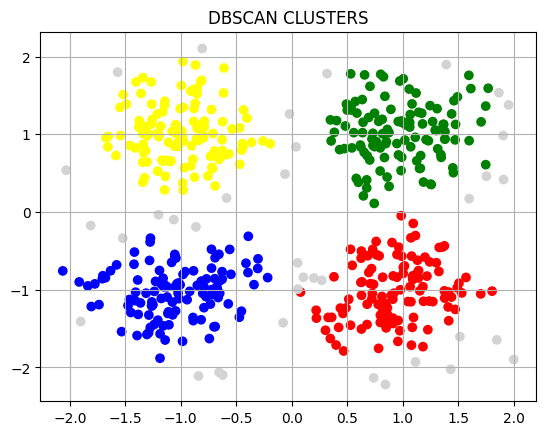

In [289]:
fix6, ax6 = plt.subplots()

# Building the label to colour mapping 
colours = {} 
colours[0] = 'red'
colours[1] = 'green'
colours[2] = 'blue'
colours[3] = 'yellow'
colours[4] = 'orange'
colours[-1] = 'lightgrey'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels]
 

# according to the colour vector defined 
ax6.scatter(X[:,0], X[:,1], c = cvec) 

ax6.set_title('DBSCAN CLUSTERS')
ax6.grid(True)

plt.show() 